In [40]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, \
    AutoModelForQuestionAnswering, Trainer, TrainingArguments, HfArgumentParser
from helpers import prepare_dataset_nli, prepare_train_dataset_qa, \
    prepare_validation_dataset_qa, QuestionAnsweringTrainer, compute_accuracy
import os
from torch.utils.data.sampler import BatchSampler, RandomSampler
from torch.utils.data import DataLoader
import json
import torch
import torch.nn as nn
import torch.functional as F
import datasets
from transformers import AutoConfig, AutoTokenizer
from datasets import get_dataset_config_names
import nltk
from infersent.models import InferSent
import pandas as pd

In [41]:
dataset = datasets.load_dataset('snli',split='validation')
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
vocab_size = tokenizer.vocab_size

Found cached dataset snli (/Users/evan/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)


In [42]:
print(len(dataset))

10000


In [43]:
def get_infersent_embedder(K=100000):
    V = 2
    MODEL_PATH = 'encoder/infersent%s.pkl' % V
    params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
                    'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
    infersent = InferSent(params_model)
    infersent.load_state_dict(torch.load(MODEL_PATH))
    W2V_PATH = 'fastText/crawl-300d-2M.vec'
    infersent.set_w2v_path(W2V_PATH)
    infersent.build_vocab_k_words(K=K)
    return infersent


class HypOnly(nn.Module):
    # Just a FF Network
    def __init__(self, d_embed, d_hidden, d_output):
        """
        :param vocab_size: vocabulary size of the embedding layer
        :param d_embed: see TransformerLayer
        :param d_internal: see TransformerLayer
        :param d_output: number of classes predicted at the output layer; should be 3
        :param num_layers: number of TransformerLayers to use; can be whatever you want
        """
        super().__init__()
        # self.IE = nn.Embedding(num_embeddings=vocab_size, embedding_dim=d_embed)
        self.prediction = nn.Sequential(
            nn.Linear(d_embed, d_hidden),
            nn.ReLU(),
            nn.Linear(d_hidden, d_hidden),
            nn.ReLU(),
            nn.Linear(d_hidden, d_output),
            nn.LogSoftmax(dim=2)
        )
        self.prediction = nn.Linear(d_embed, d_output)  # only using one layer

    def forward(self, input_: torch.tensor):
        """

        :param input_: a sequence of size (num_examples, seq_len , 1) or (seq_len,)
        :return: A tuple of the softmax log probabilities (should be a 20x3 matrix) and a list of the attention
        maps you use in your layers (can be variable length, but each should be a 20x20 matrix)
        """
        if input_.is_cuda:
            device = input_.get_device()
        else:
            device = torch.device("cpu")
        # print(device)
        output = self.prediction(input_).to(device)

        return output


In [58]:
def eval_model():
    nltk.download('punkt')
    batch_size = 64
    K = 100000
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_state = torch.load('base_model_params.pt', map_location=device)['model_state_dict']
    model = HypOnly(4096, 4096, 3).to(device)
    model.load_state_dict(model_state)
    model.eval()
    dev_set = datasets.load_dataset('snli', split='validation').with_format('torch', device=device) \
        .filter(lambda ex: ex['label'] != -1)
    # train_loader = train_set.map(lam  bda x: print(x['hypothesis'][0]), batched=False)
    print(dev_set.info.features)
    sampler = BatchSampler(RandomSampler(dev_set), batch_size=10000, drop_last=False)
    dev_loader = DataLoader(dev_set, sampler=sampler)
    infer_embedder = get_infersent_embedder(K)

    folder = 'results'
    os.makedirs(folder,exist_ok=True)
    i=0
    correct=0
    for batch in (dev_loader):
        x = torch.from_numpy(infer_embedder.encode(list(map(lambda x: x[0], batch['hypothesis'])))).to(device)
        y = torch.squeeze(batch['label'])
        model.zero_grad()
        y_hat = model.forward(x)
        y_hat = torch.argmax(y_hat, dim=1)
        correct += (y_hat == y).float().sum()
        with open(f'{folder}/xs_{i}.csv','w') as f:
            f.write('\n'.join(map(lambda x: x[0], batch['hypothesis'])))
        pd.DataFrame(y_hat).to_csv(f'{folder}/ys_{i}.csv',index=False)
        pd.DataFrame(y).to_csv(f'{folder}/y_true_{i}.csv',index=False)
        i+=1
        break
    accuracy = 100 * correct / len(dev_set)


    print("Accuracy = {}".format(accuracy))
    with open('results.txt', 'w') as f:
        f.write("Accuracy = {}".format(accuracy))
        # print(loss)

In [59]:
eval_model()

[nltk_data] Downloading package punkt to /Users/evan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Found cached dataset snli (/Users/evan/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)
Loading cached processed dataset at /Users/evan/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-2bf5c4fd5d62dd99.arrow


{'premise': Value(dtype='string', id=None), 'hypothesis': Value(dtype='string', id=None), 'label': ClassLabel(names=['entailment', 'neutral', 'contradiction'], id=None)}
Vocab size : 100000


/Users/evan/PycharmProjects/CS388-NLP-FinalProject/infersent/models.py:207: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sentences = np.array(sentences)[idx_sort]


Accuracy = 54.795772552490234


In [61]:
xs = pd.DataFrame(open('results/xs_0.csv').readlines())
ys = pd.read_csv('results/ys_0.csv')
y_true = pd.read_csv('results/y_true_0.csv')

In [63]:
dataset = pd.concat([xs,ys,y_true],axis=1)
dataset.columns = ['hypothesis', 'guess','actual']
dataset['hypothesis'] = dataset['hypothesis'].str.strip()

In [67]:
incorrect = dataset.loc[dataset['guess'] != dataset['actual']]

In [70]:
incorrect.groupby(['actual','guess']).count()

hypothesis
actual guess            
0      1             723
       2             534
1      0             891
       2             462
2      0             983
       1             856

In [71]:
dataset.groupby(['actual','guess']).count()

hypothesis
actual guess            
0      0            2072
       1             723
       2             534
1      0             891
       1            1882
       2             462
2      0             983
       1             856
       2            1439

In [73]:
dataset.loc[dataset['guess']==2]

,hypothesis,guess,actual
0,The guy is watching tv.\n,2,2
3,A dripping wet woman walks in front of a water...,2,1
5,The man is spray painting the walls in the aud...,2,2
9,The woman is in the bathroom.\n,2,2
16,a woman is playing a piano.\n,2,2
...,...,...,...
9835,The girls and boys dance.\n,2,2
9836,He is jumping over a house\n,2,2
9837,The woman is sitting in her kitchen.\n,2,2
9839,A woman is sitting on her bed.\n,2,2


In [74]:
dataset.loc[dataset['guess']==1]

,hypothesis,guess,actual
6,People ride the train into the city.\n,1,1
8,The man is hiking up the side of the mountain ...,1,1
11,The man is a drum instructor.\n,1,1
12,Some people are riding bikes down a country la...,1,2
18,A man is standing on the road to catch a ride.\n,1,2
...,...,...,...
9815,The comedian is telling jokes.\n,1,2
9817,The couple is biking through Central Park.\n,1,1
9818,The group of people has a person doing a dance...,1,0
9821,The man is running around on the field as peop...,1,2


In [75]:
dataset.loc[dataset['guess']==0]

,hypothesis,guess,actual
1,Some kids play in the backyard.\n,0,2
2,man and woman walk near water.\n,0,0
4,A man plays the drums\n,0,2
7,The man is holding a black umbrella\n,0,2
10,a woman is looking at her phone\n,0,0
...,...,...,...
9827,two women are outside\n,0,0
9831,The man has some dirt on his hands.\n,0,1
9834,The person is from Italy\n,0,2
9838,The young man is moving.\n,0,0


In [83]:
test = dataset.loc[dataset['hypothesis'].str.contains('because')]
test.groupby(['actual','guess']).count()

hypothesis
actual guess            
1      1              16
       2               3
2      1               4

In [86]:
test = dataset.loc[dataset['hypothesis'].str.contains('no')]
test.groupby(['actual','guess']).count()


hypothesis
actual guess            
0      0              51
       1              34
       2              24
1      0              22
       1              72
       2              18
2      0              43
       1              38
       2              60

In [88]:
import spacy

In [92]:
nlp = spacy.load('en_core_web_sm')

In [101]:
lemma = []
pos = []
tag = []

for doc in nlp.pipe(dataset['hypothesis'].astype('unicode').values, batch_size=50,
                        n_process=-1):
    if doc.has_annotation('DEP'):
        lemma.append([n.lemma_ for n in doc])
        pos.append([n.pos_ for n in doc])
        tag.append([n.tag_ for n in doc])
    else:
        # We want to make sure that the lists of parsed results have the
        # same number of entries of the original Dataframe, so add some blanks in case the parse fails
        lemma.append(None)
        pos.append(None)
        tag.append(None)

dataset['hp_lemma'] = lemma
dataset['hp_pos'] = pos
dataset['hp_tag'] = tag

/var/folders/gv/1ny6bb3s6415w8wy9p54pgph0000gn/T/ipykernel_73123/3758562875.py:7: DeprecationWarning: [W107] The property `Doc.is_parsed` is deprecated. Use `Doc.has_annotation("DEP")` instead.
  if doc.is_parsed:


In [102]:
dataset['hp_tokens']

0                         [The, guy, is, watching, tv, .]
1                [Some, kids, play, in, the, backyard, .]
2                 [man, and, woman, walk, near, water, .]
3       [A, dripping, wet, woman, walks, in, front, of...
4                             [A, man, plays, the, drums]
                              ...                        
9837       [The, woman, is, sitting, in, her, kitchen, .]
9838                     [The, young, man, is, moving, .]
9839             [A, woman, is, sitting, on, her, bed, .]
9840    [A, man, in, a, pink, uniform, glides, down, h...
9841                             [A, dog, is, outside, .]
Name: hp_tokens, Length: 9842, dtype: object

In [126]:
from collections import Counter
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/evan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [182]:
dataset[['guess','hypothesis']].groupby('guess').count()

,hypothesis
guess,
0,3946
1,3461
2,2435


In [153]:
gby = dataset[['guess','actual','hp_lemma','hp_pos','hp_tag']].groupby(['guess','actual'])
counter_guess_2 = Counter(dataset.loc[dataset['guess']==2]['hp_lemma'].sum())
counter_guess_1 = Counter(dataset.loc[dataset['guess']==1]['hp_lemma'].sum())
counter_guess_0 = Counter(dataset.loc[dataset['guess']==0]['hp_lemma'].sum())
counter_actual_2 = Counter(dataset.loc[dataset['actual']==2]['hp_lemma'].sum())
counter_actual_1 = Counter(dataset.loc[dataset['actual']==1]['hp_lemma'].sum())
counter_actual_0 = Counter(dataset.loc[dataset['actual']==0]['hp_lemma'].sum())


In [183]:
x = pd.DataFrame.from_dict(counter_guess_2, orient='index', columns=[2])
x /= x[2].sum()
y = pd.DataFrame.from_dict(counter_guess_1, orient='index', columns=[1])
y /= y[1].sum()
z = pd.DataFrame.from_dict(counter_guess_0, orient='index', columns=[0])
z /= z[0].sum()
a = x.join(y).join(z)
a = a.loc[~a.index.isin(stop)]
b = y.join(x).join(z)
b = b.loc[~b.index.isin(stop)]
c = z.join(x).join(y)
c = c.loc[~c.index.isin(stop)]

<AxesSubplot: >

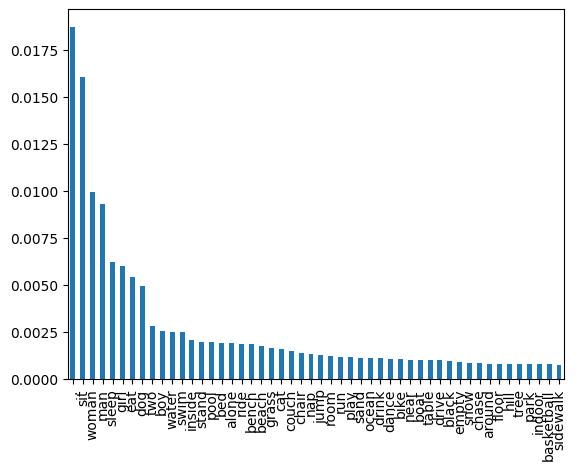

In [184]:
a['result'] = a[2] - a[1]
a['result'].loc[a['result'] > 0].sort_values(ascending=False)[:50].plot(kind='bar')


In [ ]:
b['result'] = b[1] - a[1]
a['result'].loc[a['result'] > 0].sort_values(ascending=False)[:50].plot(kind='bar')

<AxesSubplot: >

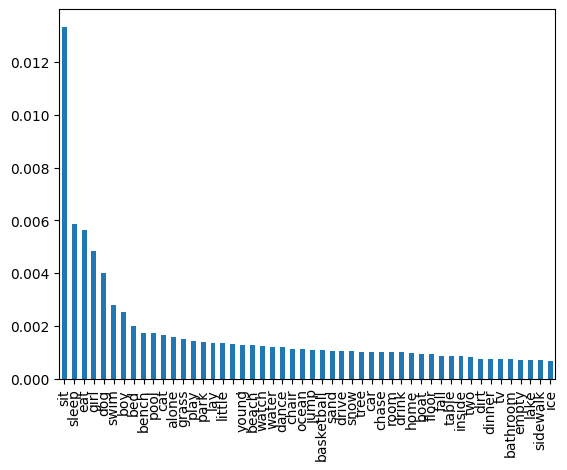

In [185]:
a['result'] = a[2] - a[0]
a['result'].loc[a['result'] > 0].sort_values(ascending=False)[:50].plot(kind='bar')

<AxesSubplot: >

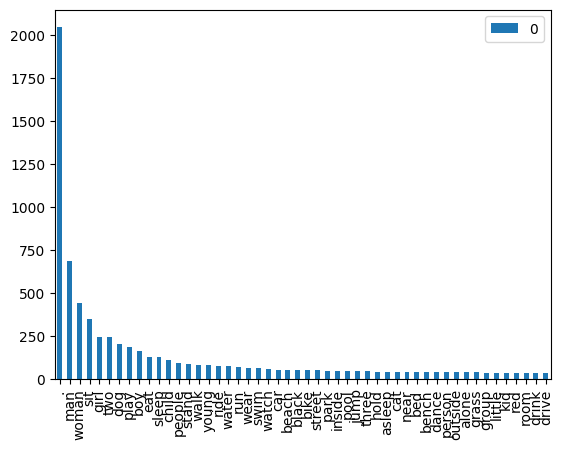

In [152]:
df = pd.DataFrame.from_dict(counter_guess_2, orient='index')
z = df.loc[~df.index.isin(stop)].sort_values(by=0,ascending=False)[:50]
z.plot(kind='bar')

<AxesSubplot: >

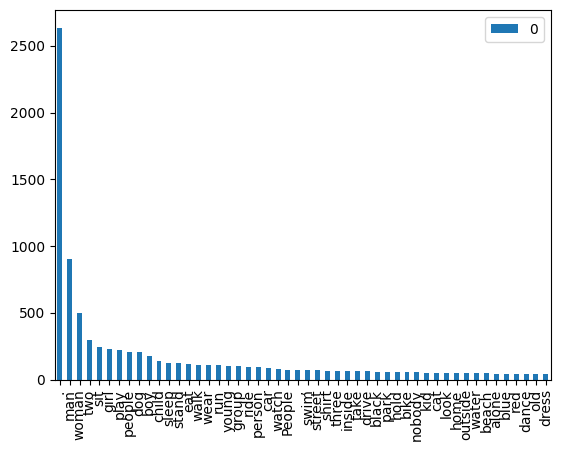

In [144]:
df = pd.DataFrame.from_dict(counter_actual_2, orient='index')
z = df.loc[~df.index.isin(stop)].sort_values(by=0,ascending=False)[:50]
z.plot(kind='bar')

<AxesSubplot: >

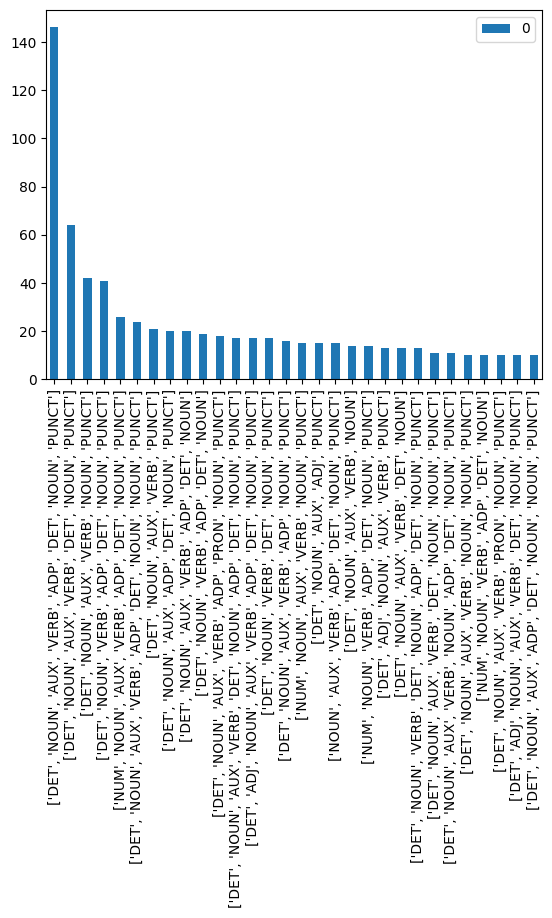

In [147]:
counter_guess_2 = Counter(dataset.loc[dataset['guess']==2]['hp_pos'].astype('str'))
df = pd.DataFrame.from_dict(counter_guess_2, orient='index')
z = df.loc[~df.index.isin(stop)].sort_values(by=0,ascending=False)[:30]
z.plot(kind='bar')

<AxesSubplot: >

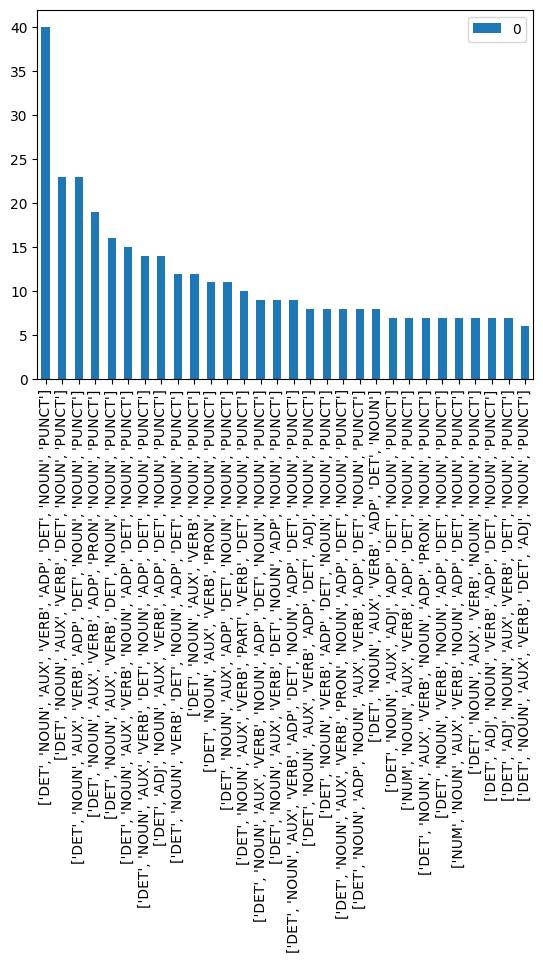

In [149]:
counter_guess_2 = Counter(dataset.loc[dataset['guess']==1]['hp_pos'].astype('str'))
df = pd.DataFrame.from_dict(counter_guess_2, orient='index')
z = df.loc[~df.index.isin(stop)].sort_values(by=0,ascending=False)[:30]
z.plot(kind='bar')

<AxesSubplot: >

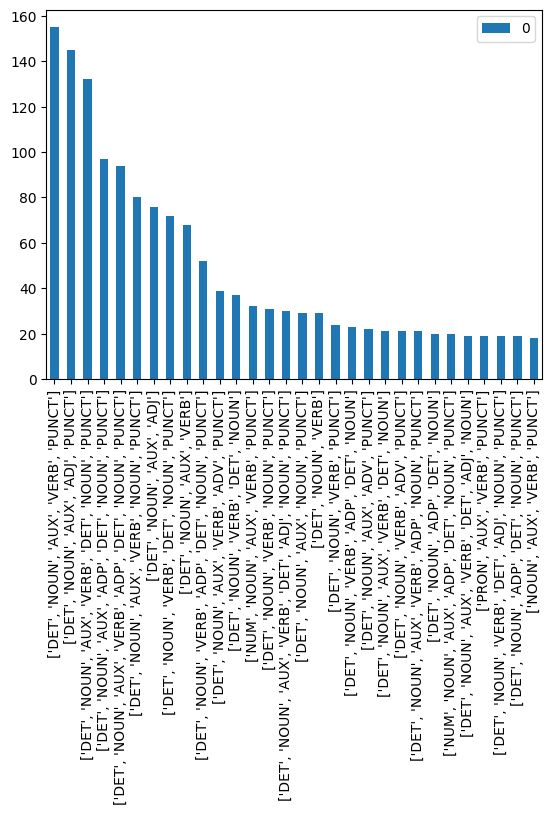

In [150]:
counter_guess_2 = Counter(dataset.loc[dataset['guess']==0]['hp_pos'].astype('str'))
df = pd.DataFrame.from_dict(counter_guess_2, orient='index')
z = df.loc[~df.index.isin(stop)].sort_values(by=0,ascending=False)[:30]
z.plot(kind='bar')